<a href="https://colab.research.google.com/github/bebek620/Practice-CNN/blob/main/CNN_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
# dataset link: https://drive.google.com/drive/folders/1Pjs2Ie04rizGx3mOoUqomy5Qr2lQ_IyG?usp=sharing
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## CONVOLUTIONAL NEURAL NETWORK USING KERAS

### Import Library

In [9]:
import numpy as np 
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from IPython.display import clear_output
import random

import os
print(os.listdir("/content/drive/MyDrive/Dataset_Cat-and-Dog"))

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

['Train', 'Test']


### Prepare Traning Data

In [3]:
filenames = os.listdir("/content/drive/MyDrive/Dataset_Cat-and-Dog/Train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
  
df = pd.DataFrame({'filename' : filenames, 'category':categories}).astype(str)

### Check Training Data set

In [4]:
df.head()

,filename,category
0,cat.107.jpg,0
1,cat.108.jpg,0
2,cat.109.jpg,0
3,cat.11.jpg,0
4,cat.110.jpg,0


In [5]:
df.tail()

,filename,category
2005,dog.102.jpg,1
2006,dog.103.jpg,1
2007,dog.104.jpg,1
2008,dog.105.jpg,1
2009,dog.106.jpg,1


### See Total Training Dataset In count using Bar chart

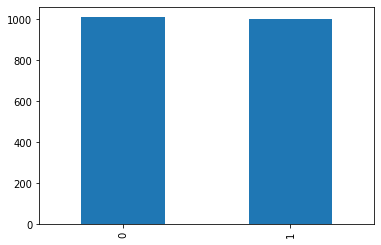

In [ ]:
df['category'].value_counts().plot.bar()

### See sample image

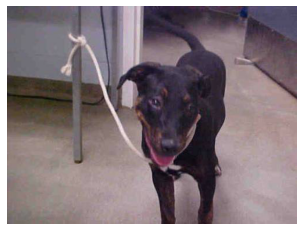

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/Dataset_Cat-and-Dog/Train/"+sample)
plt.imshow(image)
plt.axis("off")
plt.show()

<center><h1>Build Model</h1></center>

<p>The convolutional and pooling layers are followed by a dense fully connected layer that interprets the features extracted by the convolutional part of the model. A flatten layer is used between the convolutional layers and the dense layer to reduce the feature maps to a single one-dimensional vector.</p>

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

<br> <font size="2">https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/</font></br>

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

<center><h1>Callbacks</h1></center>
<p>A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.</p>

**Early Stop**

early stop is techniq for Stop training when a monitored quantity has stopped improving. 
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

**Learning Rate Reduction**
<p>Models often benefit from reducing the learning rate by a factor of **2-10 once learning stagnates**. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.</p>
<br>We will reduce the learning rate when then accuracy not increase for 2 steps</br>

<br>https://keras.io/callbacks/</br>

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

### Prepare Train and Validation Data

In [ ]:
# use 80% for training data and 20% for validation
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

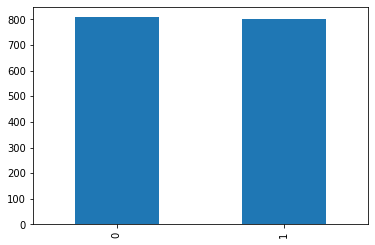

In [ ]:
# training data
train_df['category'].value_counts().plot.bar()

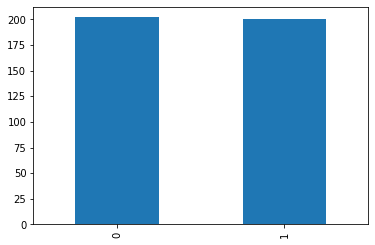

In [ ]:
# validation data
validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15
print("the total training data is =",total_train)
print("the total validation data is =",total_validate)

the total training data is = 1608
the total validation data is = 402


### Traning Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/Dataset_Cat-and-Dog/Train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 1608 validated image filenames belonging to 2 classes.


### Validation Generator

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/Dataset_Cat-and-Dog/Train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 402 validated image filenames belonging to 2 classes.


### Fit Model

The Keras utility we use for this purpose is  *ImageDataGenerator*.

*from keras.preprocessing.image import ImageDataGenerator*

This function works by flipping, rescaling, zooming, and shearing the images. The first argument rescale ensures the images are rescaled to have pixel values between zero and one. horizontal_flip=True means that the images will be flipped horizontally. All these actions are part of the image augmentation.

<br>https://heartbeat.fritz.ai/a-beginners-guide-to-convolutional-neural-networks-cnn-cf26c5ee17ed</br>

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=total_train//batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    callbacks=[plot_losses],
    verbose=1)

# Evaluate final test loss and accuracy scores
score_val = model.evaluate_generator(validation_generator, total_validate//64, workers=1)
score_tr  = model.evaluate_generator(train_generator, total_train//64, workers=1)
print('Train loss    :', score_tr[0])
print('Train accuracy:', score_tr[1])
print('Validation loss    :', score_val[0])
print('Validation accuracy:', score_val[1])

107/107 [==============================] - 15s 138ms/step - loss: 0.2804 - accuracy: 0.8751 - val_loss: 0.5225 - val_accuracy: 0.7641
Train loss    : 0.23780342936515808
Train accuracy: 0.9226666688919067
Validation loss    : 0.49032071232795715
Validation accuracy: 0.7555555701255798


<Figure size 432x288 with 0 Axes>

### Save Model

In [ ]:
model.save_weights("model.h5")
model.save("model-1.h5")

### Prepare Testing Data

In [ ]:
test_filenames = os.listdir("/content/drive/MyDrive/Dataset_Cat-and-Dog/Test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

### Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/Dataset_Cat-and-Dog/Test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 100 validated image filenames.


### Predict

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.


Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

### Virtaulize Result

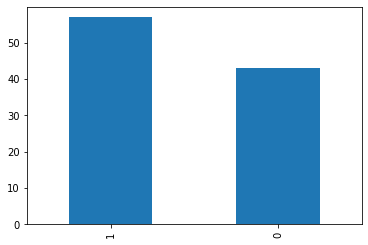

In [ ]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images 

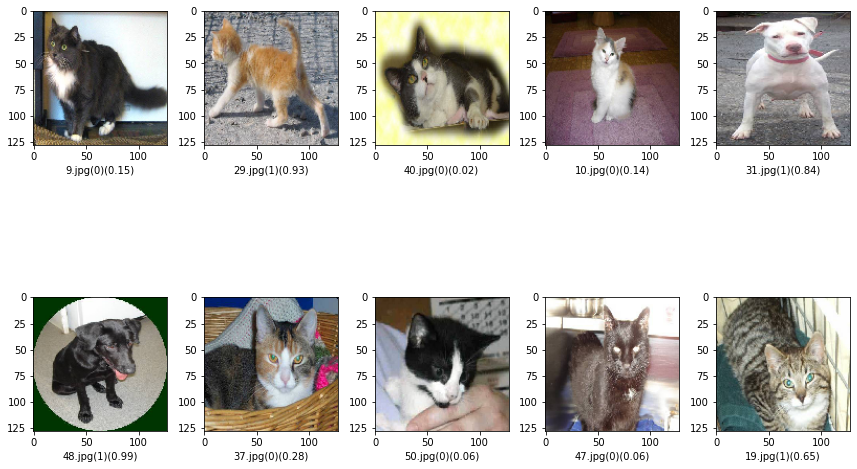

In [ ]:
sample_test = test_df.head(10)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img("/content/drive/MyDrive/Dataset_Cat-and-Dog/Test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 5, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()

### Submission

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

### Use load model

In [ ]:
from keras.models import load_model
model=load_model('model-1.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

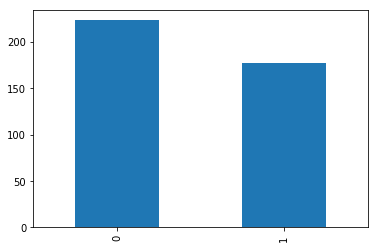

In [ ]:
test_df['category'].value_counts().plot.bar()

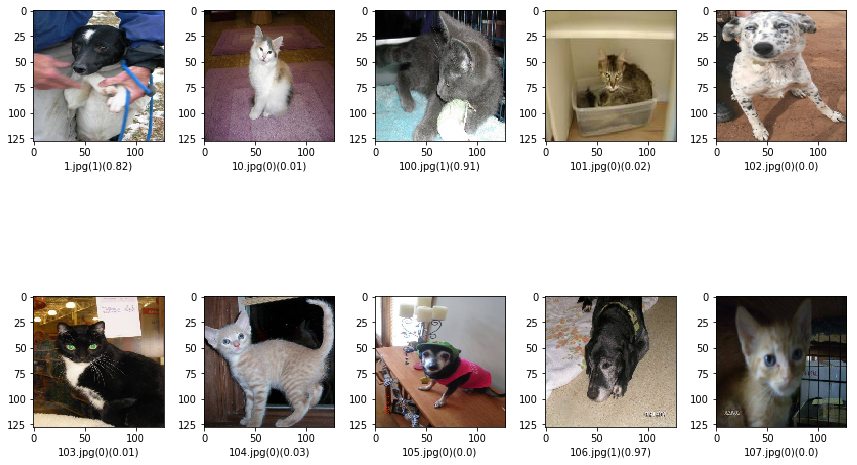

In [ ]:
sample_test = test_df.head(10)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img("./input/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 5, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()